# Tarea Semanal 4: Simulación de un ADC (cuantización) parte 2/2
## Magdalena Noé
Se simula un bloque de cuantización de un ADC de B bits en un rango de ±Vf volts, incluyendo la capacidad de muestrear a fs Hertz.
Para ello se simula el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido.
El ruido, incorrelado y Gaussiano, tendrá una potencia $P_n = k_n \cdot P_q$ Watts, siendo k el factor de escala para potencial el ruido de cuantización $P_q = \frac{q^2}{12}$

Para este experimento se trabajara con los parametros:
- $f_s$ = 1000 Hz
- $±V_F$ = 2 V
- B = 4 bits
- $k_n$ = 1

#### Librerias:

In [21]:
import numpy as np
import matplotlib.pyplot as plt #Para la visualizacion de tt y xx.
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()
import scipy.signal as sig

## Generacion de la señal discreta sR con ruido

Señal seno

In [86]:
fs = 1000 # [Hz]
N = fs    # cantidad de muestras
fo = fs/N # [Hz]
Vmax = np.sqrt(2) #[Volts]

def mi_funcion_sen(vmax=1,dc=0,ff=1,ph=0,nn=1000,fs=1000):
    t = np.arange(nn) / fs
    sin = vmax * np.sin(t*2*np.pi*ff + ph) + dc
    return t, sin

tt,analog_sig = mi_funcion_sen(fs=fs, nn=N, ff=fo, vmax=Vmax)

df = fs/N # resolución espectral

Contaminacion de la señal y cuantizacion del resultado

In [87]:
Vf = 2 #[Volts] 
B = 4 # Bits
q = Vf/2**(B)

kn = 1
Pq = q**2/12
Pn = kn * Pq # Pot ruido [Watts]
n = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N) # Ruido

sr = analog_sig + n
srq = np.round(sr / q) * q # Cuantizacion
nq = srq - sr # Error de cuantizacion

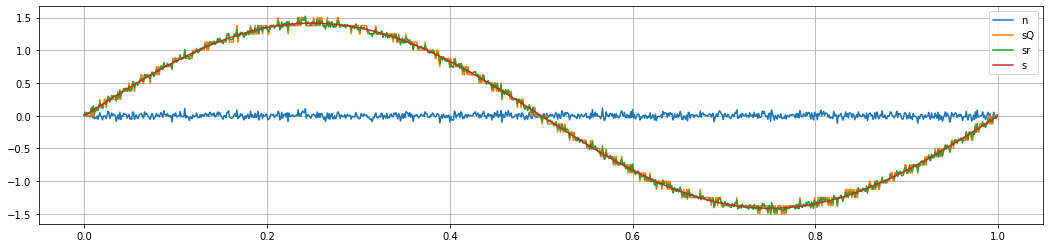

In [88]:
def graficar_funcion(abs,ord,leg="",label_y="",label_x="",titulo="",xlim=0,show=1):
    for k in np.arange(len(ord)):
        plt.plot(abs, ord[k], label=leg[k])
    if(xlim):
        plt.xlim(0, xlim)
    else:
        plt.axis('tight')

    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(titulo)
    plt.grid()
    plt.legend()
    if(show): #Para manejar subplots por fuera de la funcion
        plt.show()
    return

plt.figure(figsize=(18, 4))
graficar_funcion(tt,[n,srq,sr,analog_sig],["n","sQ","sr","s"])

## Oversampling (OS)

In [100]:
oversamp = 4
N_os = N * oversamp
fs_os = fs * oversamp
ts_os = 1/fs_os
df = fs/N
tt_os,analog_sig = mi_funcion_sen(fs=fs_os, nn=N_os, ff=fo, vmax=Vmax)

## FFT

In [101]:
#ff = np.fft.fftfreq(N, d=1/fs)
ff = np.arange(0,fs,df)
#ff_os = np.fft.fftfreq(N_os, d=df) # Reemplazar ffreq
ff_os = np.arange(0,fs_os,df)

fft_s = fft(analog_sig) / N               # Seno
ft_Srq = fft(srq) / N             # Seno con ruido cuantizado
ft_SR = fft(sr) / N             # Seno con ruido
ft_Nq = fft(nq) / N             # Error de cuantizacion
ft_As = fft(analog_sig) / N_os # Seno puro

nNn = np.random.normal(0, np.sqrt(Pn), size=N_os) # Ruido oversampling
ft_Nn = fft(nNn) / N_os
nNn_mean = np.mean(np.abs(ft_Nn)**2)
Nnq_mean = np.mean(np.abs(ft_Nq)**2)

bfrec = (ff >= 0) & (ff <= fs/2)
ff_valid = ff[bfrec]

bfrec_os = (ff_os >= 0) & (ff_os <= fs/2)
ff_os_valid = ff_os[bfrec_os]

## Gráficos

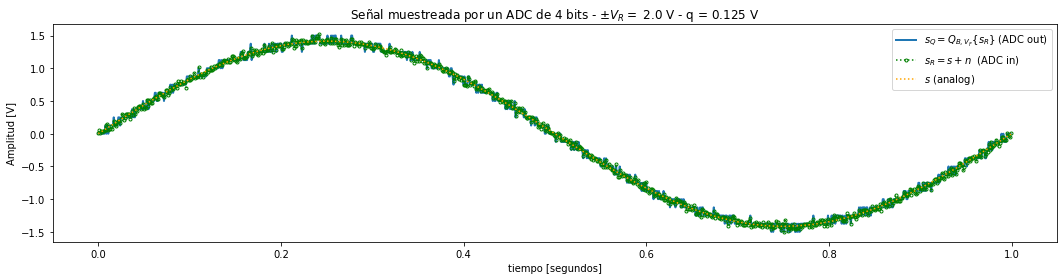

Text(0.5, 1.0, 'Ruido de cuantización para 4 bits - $\\pm V_R= $ 2.0 V - q = 0.125 V')

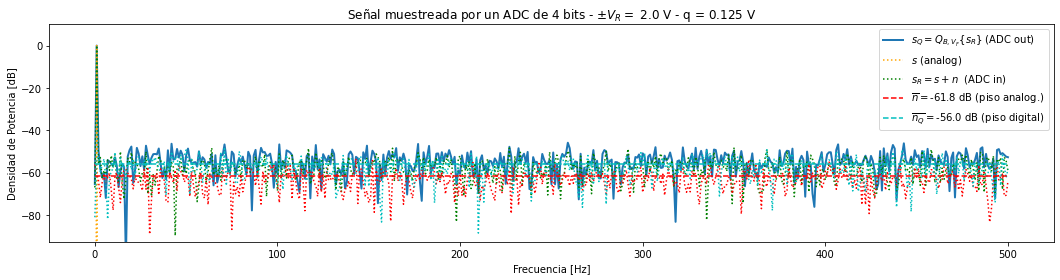

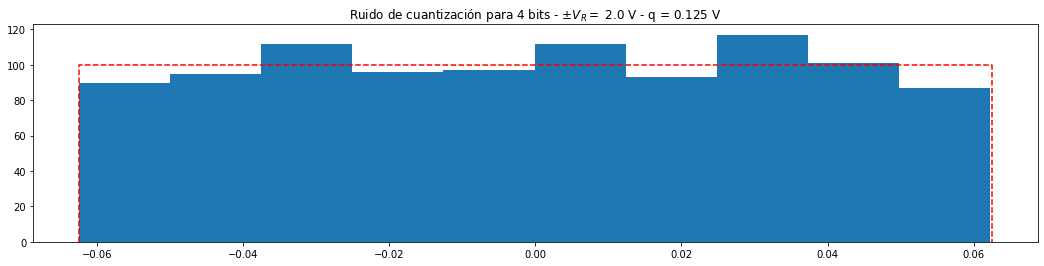

In [102]:
plt.close('all')
 
plt.figure(1, figsize=(18, 4))
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')

plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()
 
 
plt.figure(2, figsize=(18, 4))
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
 
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )

plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
 
 
plt.figure(3, figsize=(18, 4))
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))

## Observaciones

El histograma del error de cuantizacion confirma que el ruido de cuantizacion tiene una distribucion uniforme en frecuencias, asi como un ADC real.
Asi mismo, como era de esperarse, el piso de ruido de la señal cuantizada es mayor que el de la señal analogica, 
Por otro lado se observa 

El error de cuantizacion puede ser modelado como una variable aleatoria con una funcion de densidad $p_e (e)$. Así mismo, la potencia de este error es definida por una varianza ${\sigma_e^2}$, cuya dependencia a la definición de N bits del bloque cuantizador es dada por:

${\sigma_e^2} = \left( \frac{ΔV^2}{12} \right) = \left( \frac{V_{FS}^2}{12 \cdot 2^{2N}} \right) $

A partir de esta varianza se desarrolla la exprecion de SNR (signal-to-noise ratio) de la señal digitalizada, en donde se observa su dependencia de la cantidad B de bits del ADC:

$$
\text{SNR} \triangleq 10 \log_{10} \left( \frac{\sigma_x^2}{\sigma_e^2} \right) = 10 \log_{10} \left( \frac{12 \cdot 2^{2N} \sigma_x^2}{V_{FS}^2} \right) = 6.02N + 10.79 + 20 \log_{10} \left( \frac{\sigma_x}{V_{FS}} \right)
$$

<i>Fuente: Holton. DSP Principles and App. 6.7 ADC Quantization pag. 387</i>

#### A desarrollar
Efecto aliasing en el muestreo